In [8]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
from cvae import fire

In [10]:
with open('fire_frames_cropped.pkl', 'rb') as pkl_file:
    unpickler = pkl.Unpickler(pkl_file)
    frames = unpickler.load()

In [105]:
frame_pairs = []
for i in range(len(frames)):
    fire_frames = torch.from_numpy(np.array(frames[i][0]))#[:, 64:192, 64:192]
    wind_speed_frames = torch.from_numpy(np.array(frames[i][1]))#[:, 64:192, 64:192]
    wind_direction_frames = torch.from_numpy(np.array(frames[i][2]))#[:, 64:192, 64:192]
    bad_indices = []
    for i in range(len(wind_speed_frames)):
        if round(torch.max(wind_speed_frames[i]).item()) == 32767:
            bad_indices.append(i)
        elif round(torch.max(wind_direction_frames[i]).item()) == 32767:
            bad_indices.append(i)
    # remove frames with values of 32767.0000 in wind speed or direction
    mask = torch.ones(len(fire_frames), dtype=torch.bool)
    mask[bad_indices] = False
    fire_frames = fire_frames[mask]
    wind_speed_frames = wind_speed_frames[mask]
    wind_direction_frames = wind_direction_frames[mask]
    # normalize wind speed and direction to be between 0 and 1
    for i in range(len(wind_speed_frames)):
        min_val = torch.min(wind_speed_frames[i])
        wind_speed_frames[i] = (wind_speed_frames[i] - torch.min(wind_speed_frames[i])) / (torch.max(wind_speed_frames[i]) - torch.min(wind_speed_frames[i]))
        wind_direction_frames[i] = (wind_direction_frames[i] - torch.min(wind_direction_frames[i])) / (torch.max(wind_direction_frames[i]) - torch.min(wind_direction_frames[i]))
    # stack frames into pairs (only those with more than 20 frames)
    if len(fire_frames) > 20:
        # stack frames into pairs
        frame_sets = torch.stack([fire_frames[:-1], wind_speed_frames[:-1], wind_direction_frames[:-1], fire_frames[1:]], dim=1)
        frame_pairs.append(frame_sets)

frame_pairs = torch.cat(frame_pairs, dim=0)
frame_pairs = frame_pairs.type(torch.float32)
    

In [106]:
frame_pairs.shape

torch.Size([5003, 4, 128, 128])

tensor([3070,  737, 1772, 4833, 4693])


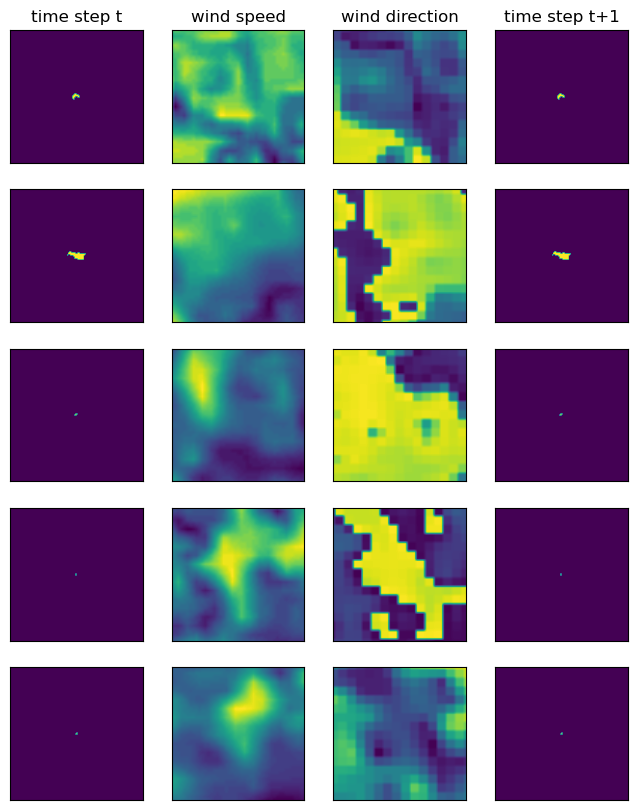

In [101]:
fig, ax = plt.subplots(5, 4, figsize=(8, 10))
randnums = torch.randperm(frame_pairs.shape[0])
frame_pairs = frame_pairs[randnums]
print(randnums[:5])
for i,x in enumerate(range(5)):
    ax[i, 0].imshow(frame_pairs[x][0])
    ax[i, 1].imshow(frame_pairs[x][1])
    ax[i, 2].imshow(frame_pairs[x][2])
    ax[i, 3].imshow(frame_pairs[x][3])
ax[0,0].set_title('time step t')
ax[0,1].set_title('wind speed')
ax[0,2].set_title('wind direction')
ax[0,3].set_title('time step t+1')
# remove ticks
for ax in ax.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [102]:
# concatenate the frames into a single tensor of shape Nx224x448
frames_with_external = torch.cat([frame_pairs[:,0], frame_pairs[:,1], frame_pairs[:,2], frame_pairs[:,3]], dim=2)

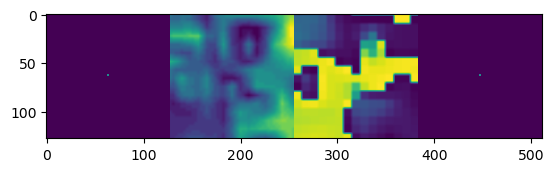

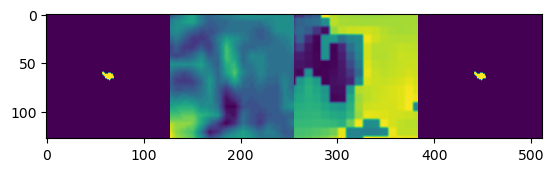

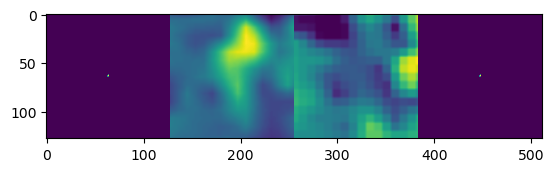

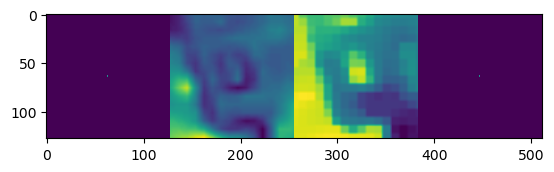

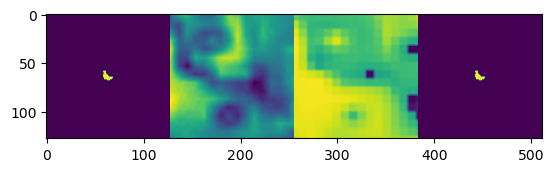

In [103]:
frames_with_external = frames_with_external[torch.randperm(frames_with_external.shape[0])]
plt.figure()
for i in range(5):
    plt.imshow(frames_with_external[i])
    plt.show()

In [104]:
# save the frames
torch.save(frames_with_external, 'data/cropped_frame_pairs_with_external.pt')

In [ ]:
frame_pairs = torch.load('data/frame_pairs_with_external.pt')

In [124]:
frames_with_external.shape

torch.Size([6009, 224, 896])